<a href="https://colab.research.google.com/github/ericzacharia/Predicting-Stocks-with-Twitter-Sentiment/blob/main/sentiment_model.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
while True:
    PRETRAINED = input(f'''Would you like to use the last saved trained model (p) or overwrite it with a new training session (train_new_model)?
p: pretrained
new: overwrite with new session
''')
    if PRETRAINED == 'p': 
        PRETRAINED = True
        break
    elif PRETRAINED == 'new':
        PRETRAINED = False
        break
    else:
        print("Invalid response. type p: pretrained, or train_new_model: overwrite with new session")

while True:
    COLAB = input(f'''Type (g) if you are using Google Colab with GPU or (l) if you are running on your local machine's CPU.
g: Google Colab
l: local 
''')
    if COLAB == 'g':
        COLAB = True
        from google.colab import drive
        drive.mount('/content/drive')
        # %pip install -r requirements.txt
        break
    elif COLAB == 'l':
        COLAB = False
        break
    else:
        print("Invalid response. type gc: Google Colab, or local: local machine")

RANDOM_SEED = 42
RISK_LEVEL = 0.2  # (conservative) 0.0 to 1.0 (risky)

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
%matplotlib inline

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path = './'
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    path = '/content/gdrive/My Drive/Transformer/'  


In [37]:
df = pd.read_csv(f"{path}data/stock_data.csv", sep=',')
df.shape

(5791, 2)

In [38]:
df.tail()

,Text,Sentiment
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1
5790,"#Sensex, #Nifty climb off day's highs, still u...",1


In [39]:
df.Sentiment.replace(-1,0,inplace=True)
df.tail()

,Text,Sentiment
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1
5790,"#Sensex, #Nifty climb off day's highs, still u...",1


In [40]:
class StockTweetsDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)}


In [41]:
# Split 80-10-10
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4632, 2), (579, 2), (580, 2))

In [42]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = StockTweetsDataset(tweets=df.Text.to_numpy(), targets=df.Sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [43]:
BATCH_SIZE = 16
MAX_LEN = 80  # All tweets in the data set contain fewer than 80 tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', return_dict=False)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [44]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.dropout(output)
    return self.out(output)


In [45]:
class_names = ['bearish', 'bullish']

if not PRETRAINED:
    data = next(iter(train_data_loader))
    data.keys()
    print(data['input_ids'].shape)
    print(data['attention_mask'].shape)
    print(data['targets'].shape)
    model = SentimentClassifier(len(class_names))
    model = model.to(device)
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    F.softmax(model(input_ids, attention_mask), dim=1)
    EPOCHS = 10
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = nn.CrossEntropyLoss().to(device)


In [46]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [47]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
PATH = 'twitter_sentiment_model.pth'  # filename for the pretrained model

if not PRETRAINED:
    %%time
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            device = torch.device("cuda")
            model.to(device)
            torch.save({
                'history': history,
                'epoch': EPOCHS,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, PATH)
            best_accuracy = val_acc
else:
    model = SentimentClassifier(len(class_names))
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

    if COLAB:
        PATH = path + PATH
        device = torch.device('cuda')
        checkpoint = torch.load(PATH)
        model.to(device)
    else:
        device = torch.device('cpu')
        checkpoint = torch.load(PATH, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    # history = checkpoint['history']

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
# # Plot training accuracy and validation accuracy
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')
# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1])

In [50]:
if not PRETRAINED:
    test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
    test_acc.item()

In [51]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweets = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)
            tweets.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweets, predictions, prediction_probs, real_values

In [52]:
# This section is used to calculate predictions and save them to a .csv file
# or load them from the saved .csv file from the pretrained model.
if not PRETRAINED:
    y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
        model, test_data_loader)
    y_pred_probs = torch.squeeze(y_pred_probs.reshape(-1, 1))
    y_pred_probs_bearish = y_pred_probs[:y_pred_probs.size(0)//2]
    y_pred_probs_bullish = y_pred_probs[y_pred_probs.size(0)//2:]
    outcome_df = pd.DataFrame({"y_tweets": y_tweets})
    outcome_df['y_pred'] = y_pred
    outcome_df['y_pred_probs_bearish'] = y_pred_probs_bearish
    outcome_df['y_pred_probs_bullish'] = y_pred_probs_bullish
    outcome_df['y_test'] = y_test
    outcome_df.to_csv(f"{path}twitter_sentiment_outcomes.csv")
else:
    outcome_df = pd.read_csv(f"{path}twitter_sentiment_outcomes.csv")
    y_tweets = outcome_df.y_tweets.tolist()
    y_pred = torch.tensor(outcome_df.y_pred.tolist())
    y_pred_probs_bearish = torch.tensor(
        outcome_df.y_pred_probs_bearish.to_list()).reshape(-1, 2)
    y_pred_probs_bullish = torch.tensor(
        outcome_df.y_pred_probs_bullish.tolist()).reshape(-1, 2)
    y_pred_probs = torch.cat((y_pred_probs_bearish, y_pred_probs_bullish), 0)
    y_test = torch.tensor(outcome_df.y_test.tolist())


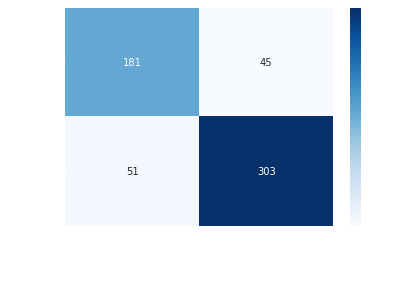

In [53]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [54]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     bearish       0.78      0.80      0.79       226
     bullish       0.87      0.86      0.86       354

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.84      0.83      0.83       580



In [122]:
# import alpaca_trade_api as tradeapi
# import api_credentials

# def cancel_pending_orders():
#     '''This section is only to be used to automate cancelling all pending
# orders that were made during code development outside of stock market hours'''
#     ALPACA_ENDPOINT_URL = api_credentials.ALPACA_ENDPOINT_URL
#     ALPACA_API_KEY = api_credentials.ALPACA_API_KEY
#     ALPACA_SECRET_KEY = api_credentials.ALPACA_SECRET_KEY
#     api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY,
#                         ALPACA_ENDPOINT_URL, api_version='v2')

#     orders = api.list_orders()
#     if len(orders) > 0:
#         for order in orders:
#             api.cancel_order(order.id)

# ### Do not uncomment, unless specifically canceling pending orders.
# cancel_pending_orders()
